# Using an LLM to generate a Travelling Salesman Problem

### My Approach

##### Initial Ideas

My first consideration was how to define the "distance" between locations in the graph. I explored three main options:

- Travel Time – This approach begins with travel time using various transport modes but could extend to reflect real-world complexities such as time of day, day of the week, and transport mode (e.g., train vs. plane). 

- Travel Cost – A practical and relevant option. However, it’s also time- and mode-dependent, and could yield unrealistic results (e.g., walking for £0). Some constraints would need to be added to keep routes reasonable.

- Physical Distance – The simplest and most straightforward option (e.g., "as the crow flies" or driving distance). While less practical and engaging, it's a good starting point to build and test the basic graph structure. This could also be extended to include distance metrics for driving distance vs train distance etc.

In this notebook, I allowed the user to specify the priority (one of "time" or "distance") however these are static and not time dependent. 

#### Implementation

Assumptions that I made: 
1. Time is constant, the results do not take into account day of week or time of day.
2. The user will enter valid inputs, i.e. not request 10 cities inside of London. 
3. Transport between nodes is symmetric. 
4. Number of nodes n, n <= 10 (this is due to limits of the GoogleMaps API). 
5. Any mode of transport is viable (I didn’t yet implement mode selection, though it would be easy to add).

The process is as follows: 
1. I use GPT-4 to suggest the nodes (e.g., landmarks or cities) for a given region.
2. I then use the Google Maps API to geocode these nodes. If this fails, I fall back to GPT-4 to generate coordinates, using a low temperature (0.0) to reduce randomness.
3. Next, I query Google Maps again for distance and travel time between all node pairs using multiple modes (walking, driving, cycling, and transit).
4. If Google Maps fails (e.g., no data for flights or boats), I fall back to GPT-4 to estimate travel between the two points, using the priority input ("shortest (distance)" or "fastest") to guide the prompt.

Once a full pairwise matrix is constructed (using the selected metric), I build a weighted graph using NetworkX and solve the Traveling Salesman Problem using networkx.algorithms.approximation.traveling_salesman_problem (note that I let the cycle be optional). 


##### Improvements / Continuation / Things that Interest me 

1. Time Dependent approach: 
    - Time-based travel information could reflect rush hour patterns, daily transit schedules, etc.
    - The graph would need to support dynamic edge weights based on traversal order — which could grow the search space significantly.
    - This would remove the assumption of symmetry (e.g., driving from A → B at 9 AM ≠ B → A at 5 PM).
    - Fuel prices and availability of routes would also need to be time-sensitive.

2. Constraints: 
    - Adding constraints like fixed start/end points, transport preferences, or budget caps would transform the problem.

3.  LLM checking mechanisms: 
    - Currently, when Google Maps fails, GPT-4 provides estimated coordinates or travel details. However, there's no validation in place.
    - A possible check for coordinates: generate surrounding landmarks, geocode those via Maps, and confirm that the LLM's coordinates fall in a reasonable proximity.

4. Multi-Criteria Priorities: 
    - I began working on a version that combines time, distance, and cost using scaled values (normalized between 0 and 1).
    - For cost, I estimated driving prices using local fuel costs and distance, while assuming walking and cycling had zero monetary cost.
    - The composite score would be:

            priority_score = α * time_norm + β * distance_norm + γ * cost_norm
            
        with weights adjustable by user input. I didn’t complete this in time, but it’s a promising direction.

In [1]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence

import re 
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem
from dotenv import load_dotenv

import googlemaps
import os
from geopy.geocoders import Nominatim
import time

from plotting import plot_graph_and_path, plot_route_folium

load_dotenv("hidden.env")

True

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
maps_API_KEY = os.getenv('maps_API_KEY')
gmaps = googlemaps.Client(key=maps_API_KEY) 
geolocator = Nominatim(user_agent="tsp")

def seconds_to_hours(seconds): 
    if type(seconds) == str:
        s = int(seconds.split())
    else: 
        s = seconds
    return s/3600

In [3]:
## First we create a prompt to ask for either landmarks, towns, cities, within the given place for the given number 

def get_location(location, number, node_type, priority): 

    if not isinstance(location, str): 
        raise ValueError("Location must be a string")
    if not isinstance(number, int) or number < 1 or number > 10: 
        raise ValueError("Number must be a positive integer <= 10.")
    if not isinstance(node_type, str):
        raise ValueError("Node type must be a string, e.g. landmarks, towns, cities.")
    if priority not in ['time', 'distance']: 
        raise ValueError("Priority must be one of [time, distance].")

    prompt1 = PromptTemplate(
        input_variables=["number", "location", "node_type"],
        template="List {number} {node_type} to visit in {location}. One per line, itemized."
    )

    chat = ChatOpenAI(model="gpt-4", temperature=0.8)
    chain = prompt1 | chat
    response = chain.invoke({"number": number,"location": location, "node_type": node_type})
    original_nodes = re.findall(r"\d+\.\s*(.+)", response.content)
    if len(original_nodes) < number: 
        # Try again 
        chain = prompt1 | chat
        response = chain.invoke({"number": number,"location": location, "node_type": node_type})
        original_nodes = re.findall(r"\d+\.\s*(.+)", response.content)

    nodes = [node + ", " + location for node in original_nodes]

    if priority == 'time': 
        p = 0
    elif priority == 'distance':
        p = 1
        
    return original_nodes, nodes, p

In [4]:
## Build the graph

def get_distances(nodes, number, p): 
    
    positions = {}
    backup_prompt = PromptTemplate(
        input_variables=["place"],
        template = "Return the longitude and latitude of {place}. "
                "In the format (latitude, longitude). No other text.")
    
    ## Now add in the LLM option (this is especially necessary for cases where the gmaps API fails)
    transport_prompt = PromptTemplate(
        input_variables=["priority_superlative", "place1", "place2"],
        template= "Return the time (in hours), the method of transport (e.g. car, plane, foot, boat, etc), "
        "the distance for that method (km), and the price (in the local currency) of using that method. "
        "This should be the {priority_superlative} way of travelling from {place1} to {place2}. "
        "Return it in this format: (method, time, distance, price). No other text.")

    for i in range(number): 
        for _ in range(3): 
            # give three attempts to get the location, if not then use the LLM to get the location
            node = geolocator.geocode(nodes[i])
            if node: 
                break 

        if not node: 
            # gmaps failed, now use the LLM with temperature set to 0.0
            chat = ChatOpenAI(model="gpt-4", temperature=0.0)
            chain = backup_prompt | chat
            response = chain.invoke({"place": nodes[i]}).content
            match = re.search(r"\(?\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)\s*\)?", response)
            if match:
                lat = float(match.group(1))
                lon = float(match.group(2))
                positions[i] = (lat, lon)
            if not match: 
                print(f"Could not find the location of {nodes[i]} using GPT-4 or geopy. Please try again.")
                return None
        else:
            positions[i] = (node.latitude, node.longitude)
            time.sleep(1) # to avoid overloading the geolocator

    coords = list(positions.values())
    ## Get the distance matrices for different methods of transport
    walking_distances = gmaps.distance_matrix(coords, coords, mode = 'walking')
    driving_distances = gmaps.distance_matrix(coords, coords, mode = 'driving')
    bicycling_distances = gmaps.distance_matrix(coords, coords, mode = 'bicycling')
    transit_distances = gmaps.distance_matrix(coords, coords, mode = 'transit')
        
    d = {} 
    lists = [walking_distances, driving_distances, bicycling_distances, transit_distances]
    mode_names = ["foot", "car", "bike", "transit"]
    for origin in range(number): 
        d[origin] = {}
        for dest in range(origin + 1, number): 
            d[origin][dest] = {}
            min_time, min_dist = np.inf, np.inf
            time_index, dist_index = 0, 0
            for i in range(4): 
                l = lists[i]
                if l['rows'][origin]['elements'][dest]['status'] == 'OK':
                    # Convert the time to hours 
                    time_taken = seconds_to_hours(l['rows'][origin]['elements'][dest]['duration']['value'])
                    # Convert the distance to km
                    dist = l['rows'][origin]['elements'][dest]['distance']['value']/1000
                    if time_taken < min_time: 
                        min_time = time_taken
                        time_index = i
                    if dist < min_dist:
                        min_dist = dist
                        dist_index = i
            
            mode1 = mode_names[time_index]
            mode2 = mode_names[dist_index]

            d[origin][dest]['t_priority'] = [mode1, min_time]
            d[origin][dest]['d_priority'] = [mode2, min_dist]

            # Here we query the LLM for methods of transport between each pair of nodes 
            # This includes flights, and other methods that are not necessarily accounted for 
            # by gmaps. 
            if min_time == np.inf or min_dist == np.inf: 

                # Change the prompt based on the priority 
                superlatives = ["fastest", "shortest (distance)"]

                chat = ChatOpenAI(model="gpt-4", temperature=0.0)
                chain = transport_prompt | chat
                for _ in range(3): 
                    response = chain.invoke({"priority_superlative": superlatives[p], "place1": nodes[origin], "place2": nodes[dest]}).content
                    match = re.search(
                        r"\(\s*(.+?)\s*,"             # Method
                        r"\s*([\d.]+)\s*\w*\s*,"      # Time (float + optional 'hours' or 'h')
                        r"\s*([\d.]+)\s*\w*\s*,"      # Distance (float + optional 'km' etc.)
                        r"\s*(?:[\$£€]|)?([\d.]+)(?:\s*\w+)?\s*\)",  # Price: optional symbol or currency word
                        response)
                    if match:
                        method = match.group(1)
                        t = float(match.group(2))
                        distance = float(match.group(3))
                        cost = float(match.group(4))
                        mode, min_time, min_dist, price = (method, t, distance, cost)
                        d[origin][dest]['t_priority'] = [mode, min_time]
                        d[origin][dest]['d_priority'] = [mode, min_dist]
                        break 

                if not match: 
                    print(f"Could not find the distance between {nodes[origin]} and {nodes[dest]}. Please enter different nodes, or try again.")
                    return None
    
    return d, positions

In [5]:
def build_graph(d, nodes, p): 

    """ A function to construct the graph using the distances between the nodes."""

    number = len(nodes)
    G = nx.complete_graph(number)
    labels = {i: nodes[i] for i in range(number)}
    p_str = ['t_priority', 'd_priority', 'c_priority'][p]

    for i in range(number): 
        for j in range(i + 1, number): 
            G[i][j]["weight"] = d[i][j][p_str][1]
    
    return G, labels

In [6]:
def solve_graph(G, p, labels, original_nodes, d, cycle = False):

    """ A function to solve the graph using the TSP algorithm from networkx. 
        The function returns the approximate path, and the total cost of the path. 
    """

    tsp_path = traveling_salesman_problem(G, weight='weight', cycle=cycle)
    total_cost = sum(G[tsp_path[i]][tsp_path[i + 1]]['weight'] for i in range(len(tsp_path) - 1))
    priority_names = ['time', 'distance', 'cost']
    priority_units = ['hours', 'km', 'local currency']

    print("TSP Approximate Path:", [labels[node] for node in tsp_path])
    print(f"Total {priority_names[p]}: {total_cost:.2f} {priority_units[p]}.")

    p_str = ['t_priority', 'd_priority', 'c_priority'][p]

    # Modes 
    for journey in range(len(tsp_path) - 1): 
        if tsp_path[journey + 1] < tsp_path[journey]: 
            print(f"{original_nodes[tsp_path[journey]]} -> {original_nodes[tsp_path[journey + 1]]}, {d[tsp_path[journey + 1]][tsp_path[journey]][p_str][0]}, {priority_names[p]}: {d[tsp_path[journey + 1]][tsp_path[journey]][p_str][1]:.2f} {priority_units[p]}.")
        else: 
            print(f"{original_nodes[tsp_path[journey]]} -> {original_nodes[tsp_path[journey + 1]]}, {d[tsp_path[journey]][tsp_path[journey + 1]][p_str][0]}, {priority_names[p]}: {d[tsp_path[journey]][tsp_path[journey + 1]][p_str][1]:.2f} {priority_units[p]}.")
        
    return tsp_path, total_cost

TSP Approximate Path: ['The Victoria and Albert Museum, London', 'Hyde Park and Kensington Gardens, London', 'Buckingham Palace, London', 'The Palace of Westminster and Big Ben, London', 'The London Eye, London', "St. Paul's Cathedral, London", 'The Shard, London', 'The Tower of London, London', 'Trafalgar Square, London', 'The British Museum, London']
Total distance: 17.35 km.
The Victoria and Albert Museum -> Hyde Park and Kensington Gardens, car, distance: 1.74 km.
Hyde Park and Kensington Gardens -> Buckingham Palace, foot, distance: 1.98 km.
Buckingham Palace -> The Palace of Westminster and Big Ben, bike, distance: 1.31 km.
The Palace of Westminster and Big Ben -> The London Eye, foot, distance: 1.32 km.
The London Eye -> St. Paul's Cathedral, foot, distance: 2.33 km.
St. Paul's Cathedral -> The Shard, bike, distance: 1.79 km.
The Shard -> The Tower of London, foot, distance: 1.52 km.
The Tower of London -> Trafalgar Square, car, distance: 3.90 km.
Trafalgar Square -> The British

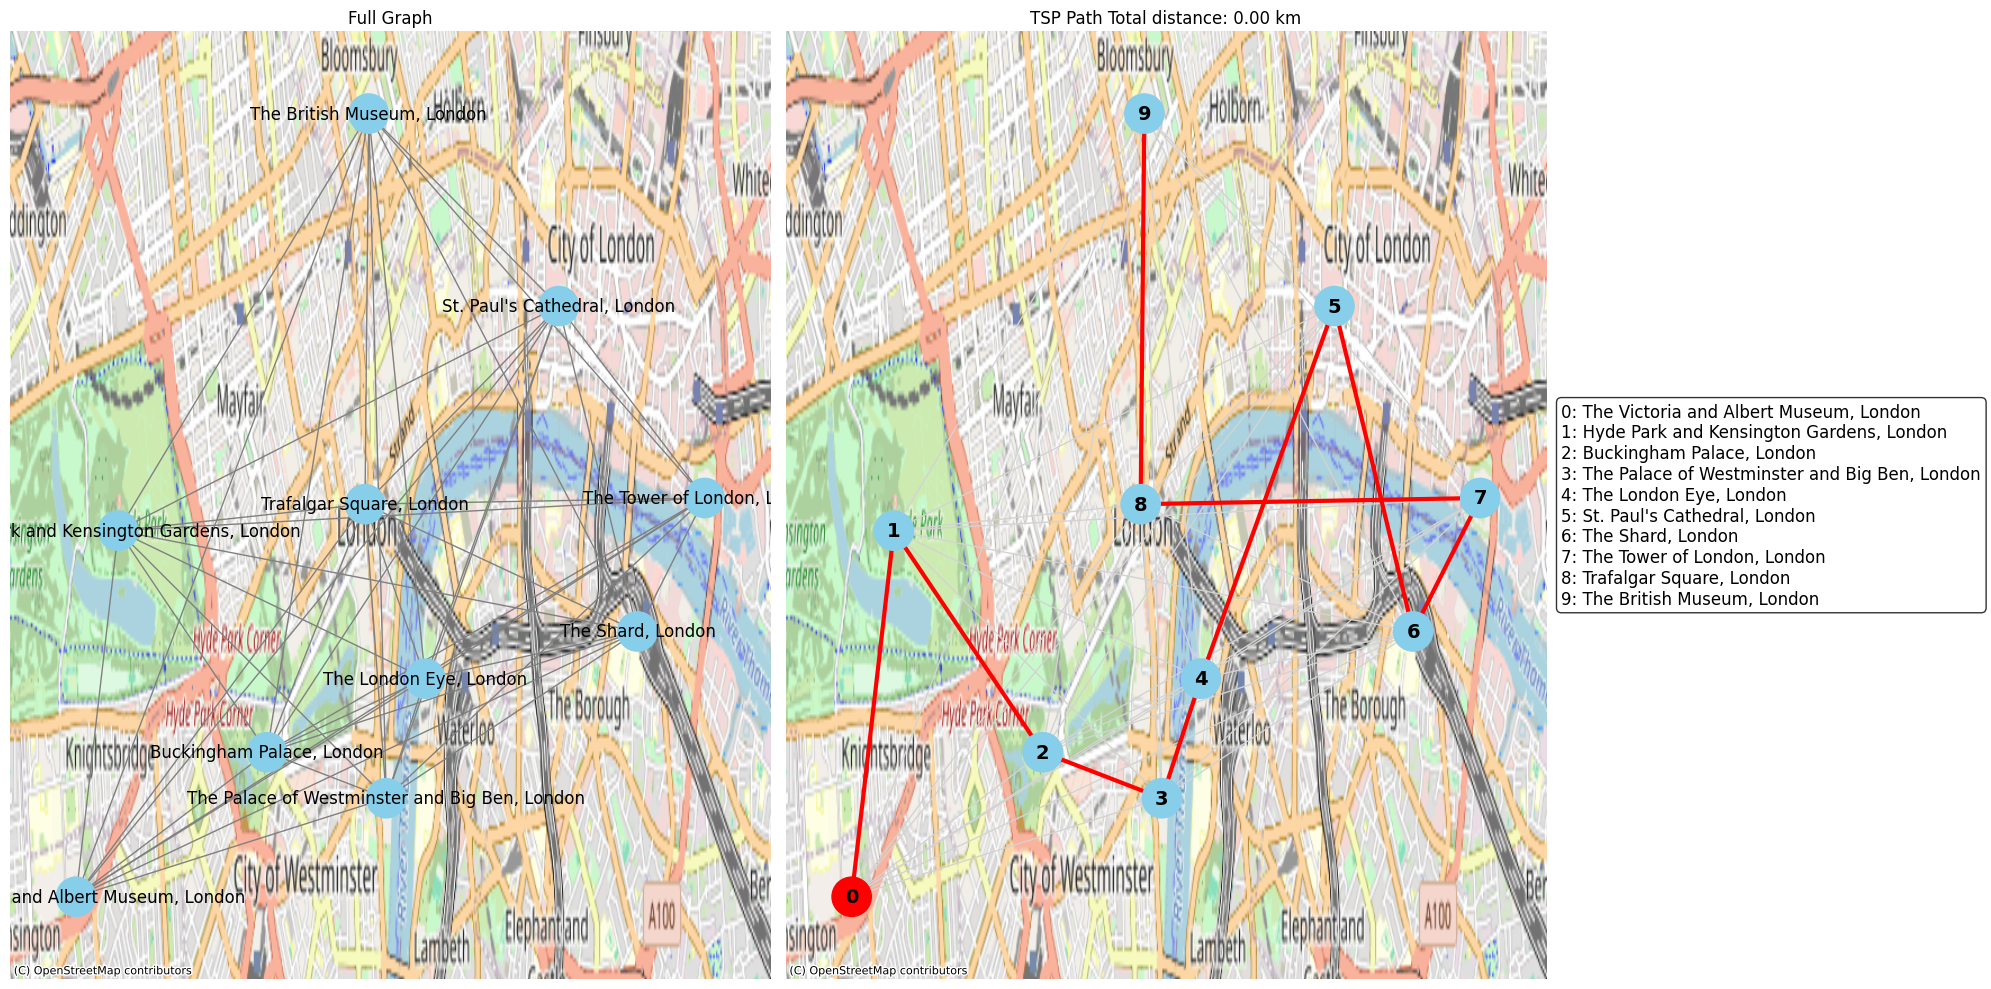

In [15]:
location = "London" # Choose a continent, country, city, town
number = 10 # This must be <= 10
node_type = "landmarks" # Choose location type, e.g. landmarks, towns, cities, countries
priority = "distance" # one of [time, distance]

original_nodes, nodes, p = get_location(location, number, node_type, priority)
d, positions = get_distances(nodes, len(nodes), p)
G, labels = build_graph(d, nodes, p)
tsp_path, total_cost = solve_graph(G, p, labels, original_nodes, d, cycle = False)  # set cycle to true if circular route is desired
plot_graph_and_path(G, tsp_path, positions, nodes, total_cost, p, map = True) 

In [13]:
from plotting import plot_route_folium
m = plot_route_folium(tsp_path, positions, nodes, total_cost, p)
m  